# ARAR Model


The **ARAR** algorithm is a specialized time-series forecasting method designed to handle data with long-memory components or complex trends. Unlike traditional models that rely on rigid structures to stationarize data, ARAR employs a dynamic, two-step process: transforming the data through "memory shortening" and then modeling the remaining signal. This approach allows ARAR to be highly automated, making it a powerful alternative for scenarios where manual model selection is impractical.

The ARAR algorithm is defined by its unique workflow, which separates the data cleaning process from the prediction process.

**Phase 1: The Memory Shortening Process**

Before any forecasting occurs, ARAR applies a series of adaptive filters to the raw data.

* Goal: To decorrelate the data and remove long-term dependencies (trends and seasonality) that confuse standard models.
* Method: It uses "memory-shortening" filters. Rather than just looking at the immediately preceding time step, these filters can subtract a fraction of a value from a longer lag (e.g., a week or a year ago).
* Result: Transformed data that is "short-memory," making it easier to predict using simple autoregressive rules.

**Phase 2: Fitting the Model**

Once the data has been transformed, the algorithm fits a standard model to the residuals.

* Model Type: It utilizes an **AR (Autoregressive)** model.
* Simplicity: Because Phase 1 does the heavy lifting of removing complex patterns, Phase 2 only needs to look at past values (an "all-pole" model) rather than modeling random shocks (Moving Averages).

**ARAR vs. ARIMA**

While both methods aim to predict future values based on history, they approach the problem from fundamentally different angles.

| Feature | ARIMA (Auto-Regressive Integrated Moving Average) | ARAR (Memory Shortening + AR) |
| :--- | :--- | :--- |
| **Transformation** | **Fixed Differencing.** It removes trends by subtracting $t$ from $t-1$ (the "Integration" step). | **Adaptive Filters.** It uses memory-shortening filters to subtract fractions of values from various time lags. |
| **Model Form** | **ARMA.** It fits a combination of Autoregressive (AR) and Moving Average (MA) terms. | **AR Only.** It fits a pure Autoregressive model to the transformed data. |
| **Automation** | **Semi-Manual.** Often requires human judgment to select orders ($p, d, q$) or complex selection criteria. | **Fully Automated.** Designed to run with minimal human intervention, making it ideal for bulk processing. |


# ARAR model theory

The ARAR model applies a memory-shortening transformation if the underlying process of a given time series ${Y_{t}, t = 1, 2, ..., n}$ is "long-memory" then it fits an autoregressive model.

## Memory Shortening

The model follows five steps to classify ${Y_{t}}$ and take one of the following three actions:


* L: declare ${Y_{t}}$ as long memory and form  ${\tilde{Y}_{t}}$ by ${\tilde{Y}_{t} = Y_{t} - \hat{\phi}Y_{t - \hat{\tau}}}$
* M: declare ${Y_{t}}$ as moderately long memory and form  ${\tilde{Y}_{t}}$ by ${\tilde{Y}_{t} = Y_{t} - \hat{\phi}_{1}Y_{t -1} - \hat{\phi}_{2}Y_{t -2}}$
* S: declare ${Y_{t}}$ as short memory.

If ${Y_{t}}$ is declared to be $L$ or $M$ then the series ${Y_{t}}$ is transformed again. The transformation process continues until the transformed series is classified as short memory. However, the maximum number of transformations is three, since it is very rare for a time series to require more than 2.

* 1. For each $\tau = 1, 2, ..., 15$, we find the value $\hat{\phi(\tau)} $ of $\hat{\phi}$ that minimizes $ERR(\phi, \tau) = \frac{\sum_{t=\tau +1 }^{n} [Y_{t} - \phi Y_{t-\tau}]^2 }{\sum_{t=\tau +1 }^{n} Y_{t}^{2}}$ then define $Err(\tau) = ERR(\hat{\phi(\tau), \tau})$ and choose the lag $\hat{\tau}$ to be the value of $\tau$ that minimizes  $Err(\tau)$.
* 2. If $Err(\hat{\tau}) \leq  8/n$,  ${Y_{t}}$ is a long-memory series.
* 3. If $\hat{\phi}( \hat{\tau} ) \geq 0.93$ and $\hat{\tau} > 2$,  ${Y_{t}}$ is a long-memory series.
* 4. If $\hat{\phi}( \hat{\tau} ) \geq 0.93$ and $\hat{\tau} = 1$ or $2$, ${Y_{t}}$ is a long-memory series.
* 5. If $\hat{\phi}( \hat{\tau} ) < 0.93$, ${Y_{t}}$ is a short-memory series.


## Subset Autoregressive Model

In the following we will describe how ARAR algorithm fits an autoregressive process to the mean-corrected series $X_{t} = S_{t}- {\bar{S}}$, $t = k+1, ..., n$ where ${S_{t}, t = k + 1, ..., n}$ is the memory-shortened version of  ${Y_{t}}$ which is derived from the five steps we described above and $\bar{S}$ is the sample mean of $S_{k+1}, ..., S_{n}$.

The fitted model has the following form:

$X_{t} = \phi_{1}X_{t-1} + \phi_{l_1}X_{t-l_{1}} + \phi_{l_2}X_{t-l_{2}} + \phi_{l_3}X_{t-l_{3}} + Z_t$

where $Z_t \sim WN(0, \sigma^{2})$. The coefficients $\phi_{j}$ and white noise variance $\sigma^2$ can be derived from the Yule-Walker equations for given lags $l_1, l_2,$ and $l_3$ :

$$
\begin{bmatrix}
1 & \hat{\rho}(l_1 - 1) & \hat{\rho}(l_2 - 1) & \hat{\rho}(l_3 - 1)\\
\hat{\rho}(l_1 - 1) &1 & \hat{\rho}(l_2 - l_1) & \hat{\rho}(l_3 - l_1)\\
\hat{\rho}(l_2 - 1) & \hat{\rho}(l_2 - l_1) & 1 & \hat{\rho}(l_3 - l_2)\\
\hat{\rho}(l_3 - 1) & \hat{\rho}(l_3 - l_1) & \hat{\rho}(l_3 - l_2) & 1
\end{bmatrix}
\ast
\begin{bmatrix}
\phi_{1} \\
\phi_{l_1} \\
\phi_{l_2}\\
\phi_{l_3}
\end{bmatrix} 
= 
\begin{bmatrix} 
\hat{\rho}(1) \\ 
\hat{\rho}(l_1) \\ 
\hat{\rho}(l_2)\\ 
\hat{\rho}(l_3) 
\end{bmatrix}
$$

and $\sigma^2 = \hat{\gamma}(0) [1-\phi_1\hat{\rho}(1) - \phi_{l_1}\hat{\rho}(l_1) - \phi_{l_2}\hat{\rho}(l_2) - \phi_{l_3}\hat{\rho}(l_3)]$, where $\hat{\gamma}(j)$ and $\hat{\rho}(j), j = 0, 1, 2, ...,$ are the sample autocovariances and autocorrelations of the series $X_{t}$.

The algorithm computes the coefficients $\phi(j)$ for each set of lags where $1<l_1<l_2<l_3 \leq m$ where $m$ is chosen to be 13 or 26. The algorithm selects the model for which the Yule-Walker estimate of $\sigma^2$ is minimal.

## Forecasting

If a short-memory filter is found in the first step, it has coefficients $\Psi_0, \Psi_1, ..., \Psi_k (k \geq0)$ where $\Psi_0 = 1$. In this case the transformed series can be expressed as
\begin{equation}
    S_t = \Psi(B)Y_t = Y_t + \Psi_1 Y_{t-1} + ...+ \Psi_k Y_{t-k},
\end{equation}
where $\Psi(B) = 1 + \Psi_1B + ...+ \Psi_k B^k$ is a polynomial in the back-shift operator.

If the subset autoregression fitted in the second step has coefficients $\phi_1, \phi_{l_1},  \phi_{l_2}$ and $\phi_{l_3}$, then the subset AR model for $X_t = S_t - \bar{S}$ is

\begin{equation}
    \phi(B)X_t = Z_t,
\end{equation}

where $Z_t$ is a white-noise series with zero mean and constant variance and $\phi(B) = 1 - \phi_1B - \phi_{l_1}B^{l_1} - \phi_{l_2}B^{l_2} - \phi_{l_3}B^{l_3}$. From equations (1) and (2) one can obtain

\begin{equation}
    \xi(B)Y_t = \phi(1)\bar{S} + Z_t,
\end{equation}
where $\xi (B) = \Psi(B)\phi(B)$.

Assuming the fitted model in equation (3) is an appropriate model, and $Z_t$ is uncorrelated with $Y_j, j <t$ $\forall t \in T$, one can determine minimum mean squared error linear predictors $P_n Y_{n + h}$ of $Y_{n+h}$ in terms of ${1, Y_1, ..., Y_n}$ for $n > k + l_3$, from the recursions

\begin{equation}
    P_n Y_{n+h} = - \sum_{j = 1}^{k + l_3} \xi_j P_nY_{n+h-j} + \phi(1)\bar{S},  h\geq 1,
\end{equation}
with the initial conditions $P_n Y_{n+h} = Y_{n + h}$, for $h\leq0$.

Ref: Brockwell, Peter J, and Richard A. Davis. Introduction to Time Series and Forecasting. [Springer](https://link.springer.com/book/10.1007/978-3-319-29854-2) (2016)

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:600;">
  <span style="margin-right:6px; font-size:22px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">

  The Python implementation of the ARAR algorithm in skforecast is based on the Julia package <a href="https://taf-society.github.io/Durbyn.jl/dev/">Durbyn.jl</a> developed by Resul Akay.

</p>

</div>

# Libraries and data

In [48]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.19.1


In [49]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.stats import Arar
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme

In [50]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00']
y = data['Gasolinas'].rename('y').rename_axis('date')
y

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
                 ...     
1989-09-01    687649.2852
1989-10-01    669889.1602
1989-11-01    601413.8867
1989-12-01    663568.1055
1990-01-01    610241.2461
Freq: MS, Name: y, Length: 253, dtype: float64

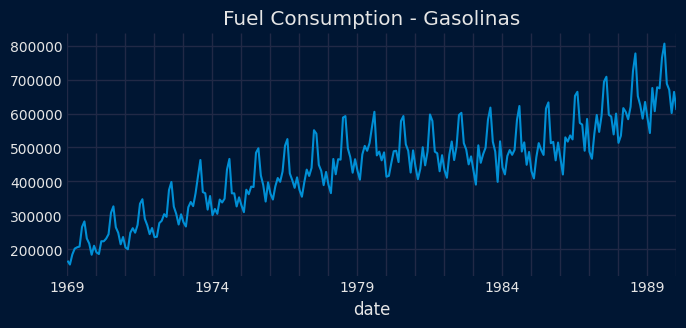

In [51]:
# Plot series
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
y.plot(ax=ax)
ax.set_title('Fuel Consumption - Gasolinas')
plt.show()

# ARAR

**Skforecast** provides the class [`ARAR`](https://skforecast.org/latest/api/stats#arar) to facilitate the creation of ARAR models in Python, allowing users to easily fit and forecast time series data using this approach.

Two arguments can be specified when creating an instance of the `ARAR` class:

+ `max_ar_depth`: Maximum lag considered when fitting the subset autoregressive model. If not specified, defaults are data-dependent: 26 for series with >40 observations, 13 for series with 13-40 observations, or max(4, ⌈n/3⌉) for shorter series.

+ `max_lag`: Maximum lag used when computing autocovariances. If not specified, defaults are data-dependent: 40 for series with >40 observations, 13 for series with 13-40 observations, or max(4, ⌈n/2⌉) for shorter series.

In [52]:
# ARAR model
# ==============================================================================
model = Arar()
model.fit(y)

,max_ar_depth,26
,max_lag,40
,safe,True


In [53]:
# Show model summary
# ==============================================================================
model.summary()

ARAR Model Summary
------------------
Number of observations: 253
Selected AR lags: (1, 2, 12, 14)
AR coefficients (phi): [ 0.139   0.5685 -0.351   0.3182]
Residual variance (sigma^2): 437274200.8454
Mean of shortened series (sbar): 2492.1575
Length of memory-shortening filter (psi): 13

Time Series Summary Statistics
Mean: 442600.9608
Std Dev: 131265.6742
Min: 155466.8105
25%: 353288.6400
Median: 454416.6016
75%: 517272.8021
Max: 805682.5000


Once the model is fitted, future observations can be forecasted using the `predict` and `predict_interval` methods.

In [54]:
# Prediction
# ==============================================================================
model.predict(steps=10)

array([576270.29065713, 711350.90294941, 645064.14251878, 699974.70526107,
       693641.4876215 , 813391.3131971 , 849840.34223407, 728834.11322404,
       698899.25161967, 640834.1450568 ])

In [55]:
# Prediction interval
# ==============================================================================
model.predict_interval(steps=10, level=[95])

,mean,lower_95,upper_95
step,,,
1,576270.290657,535285.283204,617255.298110
2,711350.902949,669971.979006,752729.826893
3,645064.142519,597182.272797,692946.012240
4,699974.705261,651641.922678,748307.487844
5,693641.487621,643148.019307,744134.955936
6,813391.313197,762568.607694,864214.018700
7,849840.342234,798207.532180,901473.152288
8,728834.113224,677001.238600,780666.987848
9,698899.251620,646741.565713,751056.937527


# ForecasterStats

The previous section introduced the construction of ARAR models. In order to seamlessly integrate these models with the various functionalities provided by **skforecast**, the next step is to encapsulate the skforecast [`ARAR`](https://skforecast.org/latest/api/stats#arar) model within a [`ForecasterStats`](https://skforecast.org/latest/api/forecasterstats) object. This encapsulation harmonizes the intricacies of the model and allows for the coherent use of skforecast's extensive capabilities.

In [56]:
# Create and fit ForecasterStats
# ==============================================================================
forecaster = ForecasterStats(estimator=Arar())
forecaster.fit(y=y)
forecaster

=============== 
ForecasterStats 
=============== 
Estimator: Arar(max_ar_depth=26, max_lag=40) 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1990-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: {'max_ar_depth': 26, 'max_lag': 40, 'safe': True} 
fit_kwargs: {} 
Creation date: 2025-12-17 19:05:59 
Last fit date: 2025-12-17 19:05:59 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1989-04-01', '1989-05-01', '1989-06-01', '1989-07-01',
               '1989-08-01', '1989-09-01', '1989-10-01', '1989-11-01',
               '1989-12-01', '1990-01-01'],
              dtype='datetime64[ns]', name='date', length=253, freq='MS') 
Skforecast version: 0.19.1 
Python version: 3.13.9 
Forecaster id: None

In [57]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_2,0.568527
1,lag_14,0.318155
2,lag_1,0.138978
3,lag_12,-0.351038


## Prediction

In [58]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=10)
predictions.head(3)

1990-02-01    576270.290657
1990-03-01    711350.902949
1990-04-01    645064.142519
Freq: MS, Name: pred, dtype: float64

In [59]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
1990-02-01,576270.290657,535285.283204,617255.298110
1990-03-01,711350.902949,669971.979006,752729.826893
1990-04-01,645064.142519,597182.272797,692946.012240


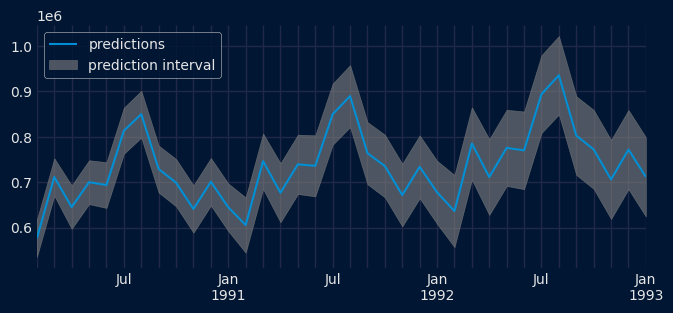

In [60]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        label='prediction interval',
        color='gray',
        alpha=0.6,
        zorder=1
    )
plt.legend()
plt.show()

## Backtesting

ARAR and other statistical models, once integrated in a [`ForecasterStats`](https://skforecast.org/latest/api/forecasterstats) object, can be evaluated using any of the [backtesting strategies](../introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [61]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
    initial_train_size = 150,
    steps              = 12,
    refit              = True,
)

metric, predictions = backtesting_stats(
    y               = y,
    forecaster      = forecaster,
    cv              = cv,
    interval        = [2.5, 97.5],
    metric          = 'mean_absolute_error',
    verbose         = False
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [62]:
# Backtesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,24021.907886


In [63]:
# Backtest predictions
# ==============================================================================
predictions.head(4)

,fold,pred,lower_bound,upper_bound
1981-07-01,0,585006.456464,548872.543529,621140.369400
1981-08-01,0,632872.256680,596247.977571,669496.535788
1981-09-01,0,515431.057548,474418.134356,556443.980739
1981-10-01,0,523423.286271,481982.529292,564864.043250


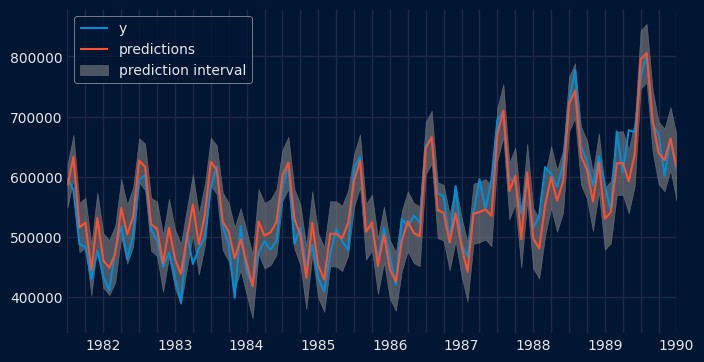

In [64]:
# Plot predictions
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 4))
y.loc[predictions.index].plot(ax=ax, label='y')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        label='prediction interval',
        color='gray',
        alpha=0.6,
        zorder=1
    )
plt.legend()
plt.show()

## Exogenous variables

When exogenous variables are provided during fitting, the model uses a
two-step approach (linear regression followed by ARAR on residuals). In this
approach, the target series is first regressed on the exogenous variables
using a linear regression model. The residuals from this regression,
representing the portion of the series not explained by the exogenous
variables, are then modeled using the ARAR model.

$$
y_t =
\underbrace{\text{linear effect of exogenous variables}}_{\text{regression}}
+
\underbrace{\text{structured residual dynamics}}_{\text{ARAR}}
+
\varepsilon_t
$$

This design allows the influence of exogenous variables to be incorporated
prior to applying the ARAR model, rather than within the ARAR dynamics
themselves.

This two-step approach is necessary because the ARAR model is inherently
univariate and does not natively support exogenous variables. By separating
the regression step, the method preserves the original ARAR formulation
while still capturing the effects of external predictors.

However, this approach carries important assumptions and implications:

- The relationship between the target series and the exogenous variables is
assumed to be linear and time-invariant.
- The ARAR model is applied only to the residual process, meaning its
parameters describe the dynamics of the series after removing the
contribution of exogenous variables.
- As a result, the interpretability of the ARAR parameters changes: they no
longer describe the full data-generating process, but rather the behavior
of the unexplained component.

Despite these limitations, this strategy provides a practical and
computationally efficient way to incorporate exogenous information into an
otherwise univariate ARAR framework.

Use this two-step regression + ARAR approach when the exogenous variables
have a clear linear effect on the target, the residual series exhibits
autocorrelation that ARAR can model, and the relationship between covariates
and the target is relatively stable over time. This method is most effective
when you want to preserve the simplicity and efficiency of ARAR while
incorporating external information. Avoid this approach if covariate effects
are strongly nonlinear, time-varying, or interact with seasonal/trend
patterns, as the residual modeling may then be inadequate.

The follwing section repeats the backtesting but this time including as exogenous variables the month of the year.

In [65]:
# Add exogenous variables to the data
# ==============================================================================
data = y.to_frame(name='y')
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Forecaster
# ==============================================================================
forecaster = ForecasterStats(estimator=Arar())
forecaster.fit(y=data['y'], exog=data.drop(columns=['y']))

In [46]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
    initial_train_size = 150,
    steps              = 12,
    refit              = True,
)

metric, predictions = backtesting_stats(
    y               = data['y'],
    exog            = data.drop(columns=['y']),
    forecaster      = forecaster,
    cv              = cv,
    interval        = [2.5, 97.5],
    metric          = 'mean_absolute_error',
    verbose         = False
)

metric

  0%|          | 0/9 [00:00<?, ?it/s]

,mean_absolute_error
0,34351.567516


## Memory optimization

For production environments where you need to store many fitted models but only require forecasting capabilities (not diagnostics), you can significantly reduce memory usage with the `reduce_memory()` method. This is specially useful when working with large datasets or deploying models in resource-constrained environments.

This method removes in-sample fitted values and residuals, which are only needed for diagnostic purposes but not for generating forecasts. After calling `reduce_memory()`, the following methods of internal estimator will raise an error:

- `fitted_()`: In-sample fitted values
- `residuals_()`: In-sample residuals  
- `score()`: R² coefficient
- `summary()`: Model summary statistics

However, prediction methods remain fully functional:

- `predict()`: Point forecasts
- `predict_interval()`: Prediction intervals

In [24]:
# Compare size before and after reduce_memory()
# ==============================================================================
import sys

forecaster = ForecasterStats(estimator=Arar())
forecaster.fit(y=y)

model_size_before = (
    sys.getsizeof(forecaster.estimator.fitted_values_) + 
    sys.getsizeof(forecaster.estimator.residuals_in_) +
    sys.getsizeof(forecaster.estimator.y_)
)
print(f"Memory before reduce_memory(): {model_size_before / 1024:.3f} KB")

# Reduce memory
forecaster.reduce_memory()
model_size_after = (
    sys.getsizeof(forecaster.estimator.fitted_values_) + 
    sys.getsizeof(forecaster.estimator.residuals_in_) +
    sys.getsizeof(forecaster.estimator.y_)
)
print(f"Memory after reduce_memory(): {model_size_after / 1024:.3f} KB")
print(f"Memory reduction: {(1 - model_size_after / model_size_before) * 100:.1f}%")

Memory before reduce_memory(): 6.258 KB
Memory after reduce_memory(): 2.117 KB
Memory reduction: 66.2%


In [26]:
# Predictions still work after memory reduction
# ==============================================================================
forecaster.predict(steps=10)

1990-02-01    576270.290657
1990-03-01    711350.902949
1990-04-01    645064.142519
1990-05-01    699974.705261
1990-06-01    693641.487621
1990-07-01    813391.313197
1990-08-01    849840.342234
1990-09-01    728834.113224
1990-10-01    698899.251620
1990-11-01    640834.145057
Freq: MS, Name: pred, dtype: float64